In [22]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import csv

In [2]:
nifti_directory = '/home/fehrdelt/data_ssd/2024_Projet_Anais/Clinical_database/all_labels'

In [3]:

# Fonction pour lire les fichiers NIfTI et obtenir les labels et les tailles des voxels
def read_nifti_files(directory):
    label_maps = []  # Liste pour stocker les matrices de labels
    voxel_sizes = []  # Liste pour stocker les tailles des voxels
    filenames = []
    for filename in os.listdir(directory):  # Parcours de tous les fichiers dans le répertoire
        #print(filename)
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):  # Filtrer les fichiers NIfTI
            filepath = os.path.join(directory, filename)  # Chemin complet du fichier
            nii = nib.load(filepath)  # Charger le fichier NIfTI
            data = nii.get_fdata()  # Obtenir les données de segmentation
            header = nii.header  # Obtenir l'en-tête pour extraire la taille des voxels
            voxel_size = header.get_zooms()[:3]  # Obtenir les dimensions des voxels (x, y, z)
            voxel_volume = np.prod(voxel_size)  # Calculer le volume d'un voxel
            label_maps.append(data)  # Ajouter les données à la liste des labels
            voxel_sizes.append(voxel_volume)  # Ajouter le volume du voxel à la liste des tailles
            filenames.append(filename)
    return label_maps, voxel_sizes, filenames


# Fonction pour obtenir les classes uniques dans les données
def get_unique_labels(labels):
    unique_labels = set()
    for label_map in labels:
        unique_labels.update(np.unique(label_map))
    unique_labels.discard(0)  # Supposer que le label 0 est le fond et doit être ignoré
    return sorted(unique_labels)


In [4]:
label_maps, voxel_sizes, filenames = read_nifti_files(nifti_directory)
unique_labels = get_unique_labels(label_maps)

label_mean_volumes = []
label_std_volumes = []

label_volumes = {}

for label in unique_labels:
    volumes = []
    for label_map, voxel_volume in zip(label_maps, voxel_sizes):
        volumes.append(np.sum(label_map == label)*voxel_volume/1000)# passage de mm3 à cm3
    label_volumes[label] = volumes
    label_mean_volumes.append(np.mean(volumes))
    label_std_volumes.append(np.std(volumes))


In [5]:
print(len(label_maps))

50


unique labels: ['Ischemia_past', 'Ischemia_new', 'Leukopathy', 'Lacuna']
mean volumes (cm³): [23.4 14.4  3.4  0.1]
std volumes (cm³): [39.2 25.9  9.5  0.2]


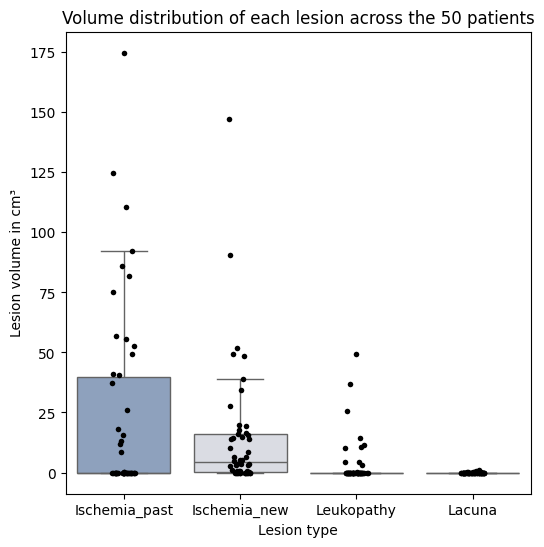

In [6]:
# change label names in the dict
label_volumes_names = {}
label_volumes_names["Ischemia_past"] = label_volumes[8.0]
label_volumes_names["Ischemia_new"] = label_volumes[9.0]
label_volumes_names["Leukopathy"] = label_volumes[10.0]
label_volumes_names["Lacuna"] = label_volumes[11.0]

df = pd.DataFrame(label_volumes_names)

f, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(df, palette="vlag", showfliers = False)
sns.stripplot(df, size=4, color="black")


# Finalize the figure
ax.set_title("Volume distribution of each lesion across the 50 patients")
ax.set_xlabel("Lesion type")
ax.set_ylabel("Lesion volume in cm³")



print("unique labels: "+ str(["Ischemia_past","Ischemia_new", "Leukopathy", "Lacuna"]))

print("mean volumes (cm³): " + str(np.round(label_mean_volumes, 1)))

print("std volumes (cm³): " + str(np.round(label_std_volumes, 1)))

## Match the distribution with a subsample of the dataset

### Make a DataFrame with all the volumes per patient

In [7]:
volumes_dict = {}
patient_id = 0

for label_map, voxel_volume in zip(label_maps, voxel_sizes):
    
    volumes_dict[patient_id] = []
    
    for label in unique_labels:
        volumes_dict[patient_id].append(np.sum(label_map == label)*voxel_volume/1000)# passage de mm3 à cm3
    
    patient_id += 1

# plutot travailler sur une dataframe des volumes par patient et par lésion
# plutot que sur toute la label map

data_frame = pd.DataFrame(volumes_dict)
data_frame.index = ['Ischemia_past', 'Ischemia_new', 'Leukopathy', 'Lacuna']
data_frame = data_frame.T
print(data_frame)

    Ischemia_past  Ischemia_new  Leukopathy    Lacuna
0        0.000000      0.292481   25.541409  0.000000
1        0.000000     49.482587    0.000000  0.000000
2        0.000000      4.887205    0.000000  0.000000
3        0.143276      0.000000    0.000000  0.000000
4        0.000000      0.714159    0.000000  0.000000
5        0.000000      3.189987    0.000000  0.000000
6       81.646808      3.334430    0.000000  0.335127
7        0.000000    147.065199    0.000000  0.000000
8        0.000000     14.384739    0.000000  0.102291
9        0.000000      2.703444    0.000000  0.000000
10      49.359761      0.582295    0.000000  0.000000
11      92.099664     14.793560    0.000000  0.000000
12      55.457813      0.000000   14.245313  0.000000
13       0.000000      3.490743    0.000000  0.037253
14     124.574873     16.430138    4.335976  0.000000
15      56.633282      0.000000    0.000000  0.000000
16       0.000000     51.704524    0.000000  0.000000
17       0.000000     34.425

In [8]:
target_ischemia_past_volumes = data_frame["Ischemia_past"].tolist()
target_ischemia_new_volumes = data_frame["Ischemia_new"].tolist()

def get_score(ischemia_past_volumes, ischemia_new_volumes):
    score = 0
    score += np.abs(np.mean(target_ischemia_past_volumes) - np.mean(ischemia_past_volumes))
    score += np.abs(np.std(target_ischemia_past_volumes) - np.std(ischemia_past_volumes))/2
    score += np.abs(np.mean(target_ischemia_new_volumes) - np.mean(ischemia_new_volumes))
    score += np.abs(np.std(target_ischemia_new_volumes) - np.std(ischemia_new_volumes))/2
    return score

In [9]:
already_picked_patients = []

def sample_with_similar_distrib(max_iter, subsample_size):

    best_patients = data_frame.sample(subsample_size, replace=False)
    best_ischemia_past_volumes = best_patients["Ischemia_past"].tolist()
    best_ischemia_new_volumes = best_patients["Ischemia_new"].tolist()


    for i in range(max_iter):

        patients = data_frame.sample(subsample_size, replace=False)
        ischemia_past_volumes = patients["Ischemia_past"].tolist()
        ischemia_new_volumes = patients["Ischemia_new"].tolist()

        if get_score(ischemia_past_volumes, ischemia_new_volumes)<get_score(best_ischemia_past_volumes, best_ischemia_new_volumes):
            best_patients = patients
            best_ischemia_past_volumes = ischemia_past_volumes
            best_ischemia_new_volumes = ischemia_new_volumes
        
    """
    print(f"generated_subsample (length: {subsample_size})")
    print(f"patients: {best_patients.index}")
    print("Mean ischemia past volume - target: "+str(np.round(np.mean(target_ischemia_past_volumes), 2))+" - subsample: "+str(np.round(np.mean(best_ischemia_past_volumes), 2)))
        
    print("Mean ischemia new volume - target: "+str(np.round(np.mean(target_ischemia_new_volumes), 2))+" - subsample: "+str(np.round(np.mean(best_ischemia_new_volumes), 2)))
        
    print("Std ischemia past volume - target: "+str(np.round(np.std(target_ischemia_past_volumes), 2))+" - subsample: "+str(np.round(np.std(best_ischemia_past_volumes), 2)))
        
    print("Std ischemia new volume - target: "+str(np.round(np.std(target_ischemia_new_volumes), 2))+" - subsample: "+str(np.round(np.std(best_ischemia_new_volumes), 2)))
    """   
       
    return best_patients


In [10]:
def print_stats_dataset(patients):
    best_ischemia_past_volumes = patients["Ischemia_past"]
    best_ischemia_new_volumes = patients["Ischemia_new"]
    print("Mean ischemia past volume - target: "+str(np.round(np.mean(target_ischemia_past_volumes), 2))+" - subsample: "+str(np.round(np.mean(best_ischemia_past_volumes), 2)))        
    print("Mean ischemia new volume - target: "+str(np.round(np.mean(target_ischemia_new_volumes), 2))+" - subsample: "+str(np.round(np.mean(best_ischemia_new_volumes), 2)))
    print("Std ischemia past volume - target: "+str(np.round(np.std(target_ischemia_past_volumes), 2))+" - subsample: "+str(np.round(np.std(best_ischemia_past_volumes), 2)))    
    print("Std ischemia new volume - target: "+str(np.round(np.std(target_ischemia_new_volumes), 2))+" - subsample: "+str(np.round(np.std(best_ischemia_new_volumes), 2)))


In [11]:
print("   ------  Test dataset  ------   ")
test_patients = sample_with_similar_distrib(5000, 10)
data_frame = data_frame.drop(test_patients.index)
print(f"patients: {test_patients.index.tolist()}")
print_stats_dataset(test_patients)


print("\n\n   ------  Step1 val dataset  ------   ")
step1_val_patients = sample_with_similar_distrib(5000, 1)
data_frame = data_frame.drop(step1_val_patients.index)
print(f"patients: {step1_val_patients.index.tolist()}")
print_stats_dataset(step1_val_patients)

print("\n   ------  Step1 train dataset  ------   ")
step1_train_patients = sample_with_similar_distrib(5000, 4)
data_frame = data_frame.drop(step1_train_patients.index)
print(f"patients: {step1_train_patients.index.tolist()}")
print_stats_dataset(step1_train_patients)



print("\n\n   ------  Step2 val dataset  ------   ")
step2_val_patients = sample_with_similar_distrib(5000, 1)
data_frame = data_frame.drop(step2_val_patients.index)
step2_val_patients = pd.concat([step2_val_patients, step1_val_patients], axis=0)
print(f"patients: {step2_val_patients.index.tolist()}")
print_stats_dataset(step2_val_patients)

print("\n   ------  Step2 train dataset  ------   ")
step2_train_patients = sample_with_similar_distrib(5000, 4)
data_frame = data_frame.drop(step2_train_patients.index)
step2_train_patients = pd.concat([step2_train_patients, step1_train_patients], axis=0)
print(f"patients: {step2_train_patients.index.tolist()}")
print_stats_dataset(step2_train_patients)



print("\n\n   ------  Step3 val dataset  ------   ")
step3_val_patients = sample_with_similar_distrib(5000, 2)
data_frame = data_frame.drop(step3_val_patients.index)
step3_val_patients = pd.concat([step3_val_patients, step2_val_patients], axis=0)
print(f"patients: {step3_val_patients.index.tolist()}")
print_stats_dataset(step3_val_patients)

print("\n   ------  Step3 train dataset  ------   ")
step3_train_patients = sample_with_similar_distrib(5000, 8)
data_frame = data_frame.drop(step3_train_patients.index)
step3_train_patients = pd.concat([step3_train_patients, step2_train_patients], axis=0)
print(f"patients: {step3_train_patients.index.tolist()}")
print_stats_dataset(step3_train_patients)



print("\n\n   ------  Step4 val dataset  ------   ")
step4_val_patients = sample_with_similar_distrib(5000, 4)
data_frame = data_frame.drop(step4_val_patients.index)
step4_val_patients = pd.concat([step4_val_patients, step3_val_patients], axis=0)
print(f"patients: {step4_val_patients.index.tolist()}")
print_stats_dataset(step4_val_patients)

print("\n   ------  Step4 train dataset  ------   ")
step4_train_patients = sample_with_similar_distrib(5000, 16)
data_frame = data_frame.drop(step4_train_patients.index)
step4_train_patients = pd.concat([step4_train_patients, step3_train_patients], axis=0)
print(f"patients: {step4_train_patients.index.tolist()}")
print_stats_dataset(step4_train_patients)


   ------  Test dataset  ------   
patients: [23, 44, 8, 38, 32, 10, 13, 4, 36, 14]
Mean ischemia past volume - target: 23.42 - subsample: 24.24
Mean ischemia new volume - target: 14.43 - subsample: 15.06
Std ischemia past volume - target: 39.19 - subsample: 38.85
Std ischemia new volume - target: 25.85 - subsample: 25.94


   ------  Step1 val dataset  ------   
patients: [49]
Mean ischemia past volume - target: 23.42 - subsample: 11.7
Mean ischemia new volume - target: 14.43 - subsample: 17.56
Std ischemia past volume - target: 39.19 - subsample: 0.0
Std ischemia new volume - target: 25.85 - subsample: 0.0

   ------  Step1 train dataset  ------   
patients: [21, 16, 2, 39]
Mean ischemia past volume - target: 23.42 - subsample: 23.56
Mean ischemia new volume - target: 14.43 - subsample: 14.33
Std ischemia past volume - target: 39.19 - subsample: 36.11
Std ischemia new volume - target: 25.85 - subsample: 21.66


   ------  Step2 val dataset  ------   
patients: [40, 49]
Mean ischemia 

In [13]:
filenames

['aini-stroke-9981-nahkypylsw-20180112-0-1_1CraneStandardMAR-CraneSansIV-000252_041.nii.gz',
 'aini-stroke-10051-zqepqwovoa-20180406-0-1_1CraneStandardMAR-CraneSansIV-000312_041.nii.gz',
 'aini-stroke-10061-pindeuwojy-20180416-0-1_1CraneStandardMAR-CraneSansIV-000304_818.nii.gz',
 'aini-stroke-10068-xrpfomwejt-20180505-0-1_1CraneSansetAvecIV-CraneSansIV-000352_418.nii.gz',
 'aini-stroke-11044-gwfthyxcby-20180318-0-3_4TroncsSupra-AortiquesVasculaireMAR-CraneSansIV-000305_905.nii.gz',
 'aini-stroke-11499-agokkefuyg-20180425-0-1_12ThrombolysePerfusion8cm-CraneSansIV-000350_818.nii.gz',
 'aini-stroke-11511-wmkkcrwabt-20181115-0-3_4TroncsSupra-AortiquesVasculaireMAR-CraneSansIV-000315_044.nii.gz',
 'aini-stroke-11522-ggromzvxsl-20180424-0-3_4TroncsSupra-AortiquesVasculaireMAR-CraneSansIV-000142_653.nii.gz',
 'aini-stroke-12194-pxjcvhdwza-20180814-0-3_22TroncsSupra-AortiquesVasculaireancien-CraneSansIV-000330_617.nii.gz',
 'aini-stroke-12228-oxggzgjbkd-20180827-0-1_1CraneStandardMAR-CraneSan

In [17]:
filenames_dict = {
    "test_patients": [filenames[i] for i in test_patients.index.tolist()],
    "step1_val_patients": [filenames[i] for i in step1_val_patients.index.tolist()],
    "step1_train_patients": [filenames[i] for i in step1_train_patients.index.tolist()],
    "step2_val_patients": [filenames[i] for i in step2_val_patients.index.tolist()],
    "step2_train_patients": [filenames[i] for i in step2_train_patients.index.tolist()],
    "step3_val_patients": [filenames[i] for i in step3_val_patients.index.tolist()],
    "step3_train_patients": [filenames[i] for i in step3_train_patients.index.tolist()],
    "step4_val_patients": [filenames[i] for i in step4_val_patients.index.tolist()],
    "step4_train_patients": [filenames[i] for i in step4_train_patients.index.tolist()]}

In [23]:


f = open('/home/fehrdelt/data_ssd/2024_Projet_Anais/datasets.csv', 'w')
writer = csv.writer(f)

for key in filenames_dict:
    writer.writerow([key]+filenames_dict[key])